# Embed, Encode, Attend and Predict

In [1]:
from __future__ import division, print_function
from keras.layers import Input
from keras.layers.core import Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.models import Model
from keras.optimizers import SGD
from keras.utils import to_categorical
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import custom_attn
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_DIR = "../data"

VOCAB_FILE = os.path.join(DATA_DIR, "ng-vocab.tsv")
MIN_OCCURS = 5

GLOVE_FILE = os.path.join(DATA_DIR, "glove.840B.300d.txt")

# covers about 95% of input data
MAX_SENTS = 40 # maximum number of sentences per document
MAX_WORDS = 60 # maximum number of words per sentence

WORD_EMBED_SIZE = 300
SENT_EMBED_SIZE = 100
DOC_EMBED_SIZE = 50
NUM_CLASSES = 20

BATCH_SIZE = 64
NUM_EPOCHS = 10

logging.basicConfig()

## Load Vocabulary

In [3]:
word2id = {"PAD": 0, "UNK": 1}
fvocab = open(VOCAB_FILE, "rb")
for i, line in enumerate(fvocab):
    word, count = line.strip().split("\t")
    if int(count) <= MIN_OCCURS:
        break
    word2id[word] = i
fvocab.close()
id2word = {v:k for k, v in word2id.items()}
vocab_size = len(word2id)
print("vocab_size: {:d}".format(vocab_size))

vocab_size: 40730


## Load GloVe Embeddings

In [4]:
E = np.zeros((vocab_size, WORD_EMBED_SIZE))
E[1] = np.random.random(WORD_EMBED_SIZE)
fglove = open(GLOVE_FILE, "rb")
for line in fglove:
    cols = line.strip().split(" ")
    word = cols[0]
    if not word2id.has_key(word):
        continue
    vec = np.array([float(x) for x in cols[1:]])
    idx = word2id[word]
    E[idx] = vec
fglove.close()
print(E.shape)

(40730, 300)


## Compute Document Vectors

In [5]:
ng_data = fetch_20newsgroups(subset='all',
                             data_home=DATA_DIR,
                             shuffle=True, 
                             random_state=42)
num_docs = len(ng_data.data)
print(num_docs)

18846


In [6]:
def pad_or_truncate(xs, maxlen):
    if len(xs) > maxlen:
        xs = xs[len(xs) - maxlen:]
    elif len(xs) < maxlen:
        xs = ["PAD"] * (maxlen - len(xs)) + xs
    return xs

xs = ["The", "cat", "fought", "like", "a", "mouse"]
print(pad_or_truncate(xs, 3))
print(pad_or_truncate(xs, 7))

['like', 'a', 'mouse']
['PAD', 'The', 'cat', 'fought', 'like', 'a', 'mouse']


In [7]:
X = np.zeros((num_docs, MAX_SENTS, MAX_WORDS))
for docid in range(num_docs):
    text = ng_data.data[docid]
    sents = pad_or_truncate(nltk.sent_tokenize(text), MAX_SENTS)
    for sid, sent in enumerate(sents):
        words = nltk.word_tokenize(sent)
        words = pad_or_truncate(words, MAX_WORDS)
        for wid, word in enumerate(words):
            try:
                word_id = word2id[word]
            except KeyError:
                word_id = word2id["UNK"]
            X[docid, sid, wid] = word_id
print(X.shape)

(18846, 40, 60)


In [8]:
y = ng_data.target
Y = to_categorical(y, num_classes=NUM_CLASSES)
print(Y.shape)

(18846, 20)


In [9]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size=0.7)
print(Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape)

(13192, 40, 60) (13192, 20) (5654, 40, 60) (5654, 20)


## Define Network

### Sentence Level

In [14]:
sent_inputs = Input(shape=(MAX_WORDS,), dtype="int32")

sent_emb = Embedding(input_dim=vocab_size,
                     output_dim=WORD_EMBED_SIZE,
                     mask_zero=True,
                     weights=[E])(sent_inputs)
# sent_enc = Bidirectional(GRU(SENT_EMBED_SIZE,
#                              return_sequences=True))(sent_emb)

# sent_att = custom_attn.AttentionMC()(sent_enc)

# sent_model = Model(inputs=sent_inputs, outputs=sent_att)

sent_enc = Bidirectional(GRU(SENT_EMBED_SIZE,
                             return_sequences=False))(sent_emb)

sent_model = Model(inputs=sent_inputs, outputs=sent_enc)

sent_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 60)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 60, 300)           12219000  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200)               240600    
Total params: 12,459,600
Trainable params: 12,459,600
Non-trainable params: 0
_________________________________________________________________


In [15]:
doc_inputs = Input(shape=(MAX_SENTS, MAX_WORDS), dtype="int32")

doc_emb = TimeDistributed(sent_model)(doc_inputs)

doc_enc = Bidirectional(GRU(DOC_EMBED_SIZE,
                            return_sequences=True))(doc_emb)

doc_att = custom_attn.AttentionMC()(doc_enc)

fc1_dropout = Dropout(0.2)(doc_att)
fc1 = Dense(50, activation="relu")(fc1_dropout)
fc2_dropout = Dropout(0.2)(fc1)
doc_pred = Dense(NUM_CLASSES, activation="softmax")(fc2_dropout)

model = Model(inputs=doc_inputs, outputs=doc_pred)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 40, 60)            0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 40, 200)           12459600  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 40, 100)           75300     
_________________________________________________________________
attention_mv_3 (AttentionMV) (None, 100)               10200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
__________

In [16]:
model.compile(optimizer="adam", loss="categorical_crossentropy",
              metrics=["accuracy"])

In [17]:
history = model.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE,
                   epochs=NUM_EPOCHS, validation_split=0.1)

Train on 11872 samples, validate on 1320 samples
Epoch 1/10
11872/11872 [==============================] - 247s - loss: 2.8317 - acc: 0.1165 - val_loss: 2.2279 - val_acc: 0.2788
Epoch 2/10
11872/11872 [==============================] - 244s - loss: 1.8484 - acc: 0.3831 - val_loss: 1.2637 - val_acc: 0.5773
Epoch 3/10
11872/11872 [==============================] - 245s - loss: 1.0202 - acc: 0.6593 - val_loss: 0.8852 - val_acc: 0.7250
Epoch 4/10
11872/11872 [==============================] - 244s - loss: 0.5526 - acc: 0.8219 - val_loss: 0.7187 - val_acc: 0.7871
Epoch 5/10
11872/11872 [==============================] - 245s - loss: 0.3097 - acc: 0.9064 - val_loss: 0.6944 - val_acc: 0.8235
Epoch 6/10
11872/11872 [==============================] - 244s - loss: 0.1707 - acc: 0.9527 - val_loss: 0.7436 - val_acc: 0.8265
Epoch 7/10
11872/11872 [==============================] - 245s - loss: 0.1155 - acc: 0.9670 - val_loss: 0.8357 - val_acc: 0.8379
Epoch 8/10
11872/11872 [========================

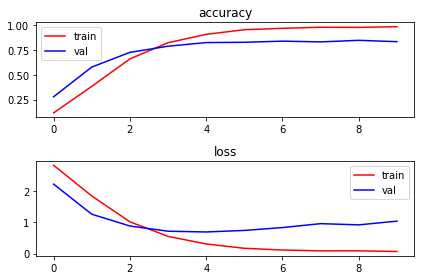

In [18]:
plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="val")
plt.legend(loc="best")

plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="val")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

## Evaluate Network

In [19]:
np.set_printoptions(linewidth=120)
Ytest_ = model.predict(Xtest)
ytest_ = np.argmax(Ytest_, axis=1)
ytest = np.argmax(Ytest, axis=1)
print("accuracy score: {:.3f}".format(accuracy_score(ytest, ytest_)))
print("\nconfusion matrix\n")
print(confusion_matrix(ytest, ytest_))

accuracy score: 0.831

confusion matrix

[[193   1   0   1   0   0   2   0   0   1   1   2   1   1   2   8   0   1   0  14]
 [  1 240  18  13   5  14   4   1   1   0   1   5   6   3   3   1   0   0   0   0]
 [  0  11 225  22  13   8   2   1   0   0   0   0   0   0   1   1   0   3   0   1]
 [  1   5  19 221  29   0   9   5   0   1   1   1   6   0   2   2   0   0   0   1]
 [  0   3   8  30 205   5   6   2   1   1   1   1   7   3   0   0   0   0   0   0]
 [  1  21  28   1   4 245   1   0   0   1   1   2   1   0   2   1   0   0   1   2]
 [  1   7   5  13   9   1 209  12   4   2   2   0   7   2   1   0   1   6   2   1]
 [  1   0   1   1   4   0   7 270   4   0   0   0   1   1   0   0   0   1   2   0]
 [  1   0   0   1   0   0   3  22 282   9   1   0   1   0   3   0   7   0   0   1]
 [  0   1   2   0   1   0   2   1   0 244  10   1   0   0   2   0   1   1   2   3]
 [  2   0   0   1   1   0   2   1   0   8 262   0   0   0   0   0   1   3   3   0]
 [  1   3   0   1   2   1   1   0   0   0   0 